# Grounded Segement Anything

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [4]:
! python -m pip install -e segment_anything
! python -m pip install -e GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

Obtaining file:///home/liushilong/code/GroundingFolder/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
print('Updated sys.path:', sys.path)

Updated sys.path: ['/home/azon/detect/myGrounded-Segment-Anything', '/home/azon/anaconda3/envs/seg2/lib/python38.zip', '/home/azon/anaconda3/envs/seg2/lib/python3.8', '/home/azon/anaconda3/envs/seg2/lib/python3.8/lib-dynload', '', '/home/azon/anaconda3/envs/seg2/lib/python3.8/site-packages', '/home/azon/detect/Grounded-Segment-Anything/segment_anything', '/home/azon/detect/Grounded-Segment-Anything/GroundingDINO', '/home/azon/anaconda3/envs/seg2/lib/python3.8/site-packages/mmpose-0.28.0-py3.8.egg', '/home/azon/anaconda3/envs/seg2/lib/python3.8/site-packages/xtcocotools-1.14.3-py3.8-linux-x86_64.egg', '/home/azon/anaconda3/envs/seg2/lib/python3.8/site-packages/munkres-1.1.4-py3.8.egg', '/tmp/tmpvnswy_k_', '/home/azon/detect/myGrounded-Segment-Anything/GroundingDINO']


In [2]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [1]:
import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
# import GroundingDINO.groundingdino.datasets.transforms as T
# from GroundingDINO.groundingdino.models import build_model
# from GroundingDINO.groundingdino.util import box_ops
# from GroundingDINO.groundingdino.util.slconfig import SLConfig
# from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
# from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

# Load Grounding DINO model

In [2]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [3]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [4]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

/home/azon/anaconda3/envs/seg2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392036766/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /home/azon/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


# Load SAM model

In [7]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-10-31 20:32:38--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.51, 3.163.189.96, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt   3%[                    ]  79.52M  9.98MB/s    eta 4m 6s  ^C


In [6]:
device=0
sam_checkpoint = '../Grounded-Segment-Anything/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

# Load stable diffusion inpainting models

In [9]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

pipe = pipe.to("cuda")

A Jupyter Widget

# Load demo image

In [7]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

In [8]:
# local_image_path = 'assets/inpaint_demo.jpg'
local_image_path = '../YG001/000089.png'
local_image_path2 = '../YG001/000093.png'

In [9]:
local_image_path.split('/')[-2]

'YG001'

In [10]:
local_image_path.split('/')[-1].split('.')[-2]

'000089'

In [27]:
basepath = '/home/azon/data/video/'
for root, dirs, files in os.walk(basepath):
    for name in files:
        print(os.path.join(root, name))

/home/azon/data/video/004QE.mp4/000605.png
/home/azon/data/video/004QE.mp4/000159.png
/home/azon/data/video/004QE.mp4/000093.png
/home/azon/data/video/004QE.mp4/000217.png
/home/azon/data/video/004QE.mp4/000332.png
/home/azon/data/video/004QE.mp4/000121.png
/home/azon/data/video/004QE.mp4/000537.png
/home/azon/data/video/004QE.mp4/000825.png
/home/azon/data/video/004QE.mp4/000459.png
/home/azon/data/video/004QE.mp4/000195.png
/home/azon/data/video/004QE.mp4/000469.png
/home/azon/data/video/004QE.mp4/000169.png
/home/azon/data/video/004QE.mp4/000276.png
/home/azon/data/video/004QE.mp4/000400.png
/home/azon/data/video/004QE.mp4/000320.png
/home/azon/data/video/004QE.mp4/000601.png
/home/azon/data/video/004QE.mp4/000452.png
/home/azon/data/video/004QE.mp4/000378.png
/home/azon/data/video/004QE.mp4/000052.png
/home/azon/data/video/004QE.mp4/000650.png
/home/azon/data/video/004QE.mp4/000238.png
/home/azon/data/video/004QE.mp4/000501.png
/home/azon/data/video/004QE.mp4/000308.png
/home/azon/

# Run Grounding DINO for detection

In [12]:
TEXT_PROMPT = "person,broom,picture,closet/cabinet,blanket,window,table,paper/notebook,refrigerator,pillow,cup/glass/bottle,shelf,shoe,medicine,phone/camera,box,sandwich,book,bed,clothes,mirror,sofa/couch,floor,bag,dish,laptop,door,towel,food,chair,doorknob,doorway,groceries,hands,light,vacuum,television"
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

image_source, image = load_image(local_image_path)
image_source2, image2 = load_image(local_image_path2)

boxes, logits, phrases = predict(
    model=groundingdino_model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

In [18]:
boxes.cpu().numpy().tolist()

[[0.7953490018844604,
  0.6254998445510864,
  0.2677916884422302,
  0.3473636209964752],
 [0.7313571572303772,
  0.7226017117500305,
  0.5375871062278748,
  0.4439876079559326],
 [0.31708818674087524,
  0.8299182653427124,
  0.3981308043003082,
  0.3396327495574951],
 [0.5365861058235168,
  0.4501444399356842,
  0.07700910419225693,
  0.15308590233325958],
 [0.0916774570941925,
  0.7042117118835449,
  0.18312588334083557,
  0.5909914374351501],
 [0.8589416742324829,
  0.7381247282028198,
  0.04586508497595787,
  0.14612317085266113],
 [0.41260531544685364,
  0.515690803527832,
  0.17885953187942505,
  0.1630484163761139],
 [0.9673430323600769,
  0.6449668407440186,
  0.06534193456172943,
  0.20254623889923096],
 [0.3373538553714752,
  0.627647340297699,
  0.4112521708011627,
  0.7419110536575317],
 [0.7436854839324951,
  0.5322449803352356,
  0.038211993873119354,
  0.1571517139673233],
 [0.6525565385818481,
  0.49136340618133545,
  0.07788816839456558,
  0.1066255047917366],
 [0.77779

In [15]:
phrases

['laptop',
 'table',
 'chair',
 'pillow',
 'blanket towel',
 'cup / glass / bottle',
 'pillow',
 'phone / television',
 'person',
 'cup / glass / bottle',
 'paper notebook box book',
 'television',
 'sofa couch',
 'cup / glass /',
 'clothes towel',
 'bed']

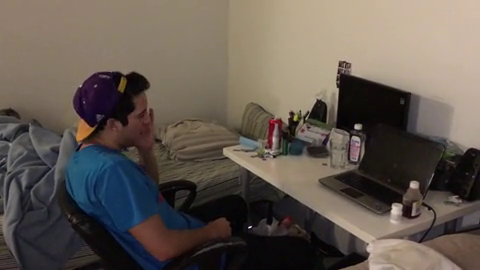

In [7]:
Image.fromarray(image_source)

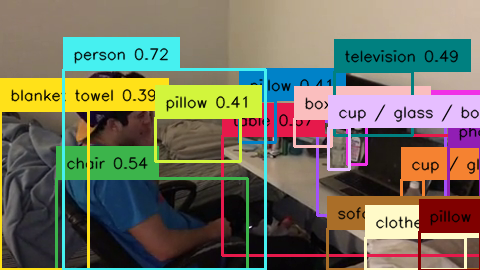

In [14]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [171]:
# set image
sam_predictor.set_image(image_source)

In [172]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [173]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [174]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [175]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

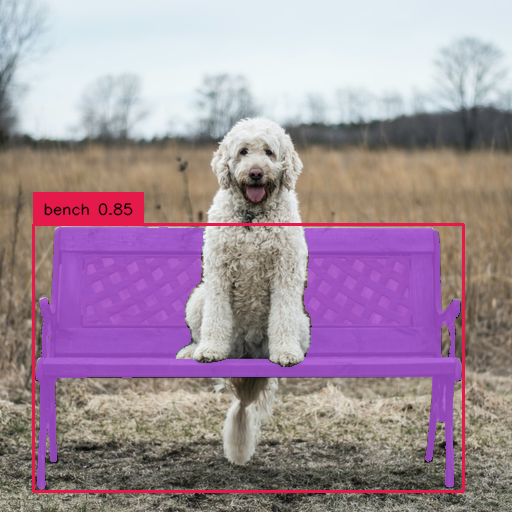

In [176]:
Image.fromarray(annotated_frame_with_mask)

# Image Inpainting

In [177]:
image_mask = masks[0][0].cpu().numpy()

In [178]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

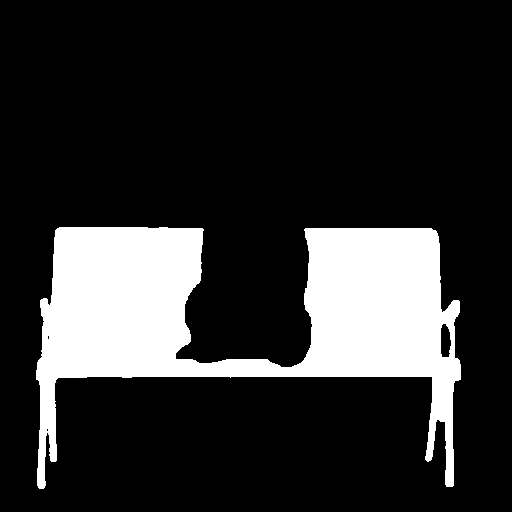

In [179]:
image_mask_pil

In [181]:
# resize for inpaint
image_source_for_inpaint = image_source_pil.resize((512, 512))
image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [182]:
prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

100%|██████████| 50/50 [00:02<00:00, 17.54it/s]


In [183]:
image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

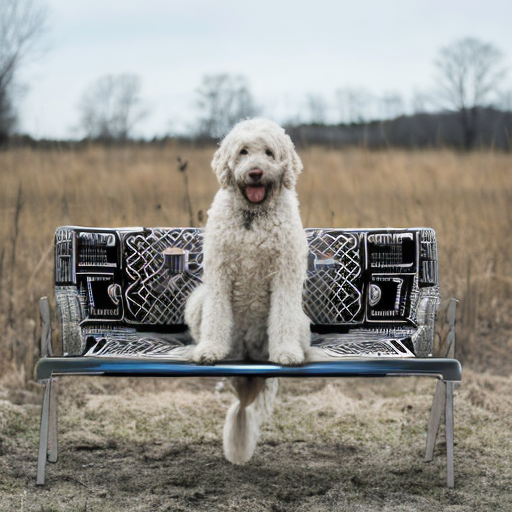

In [184]:
image_inpainting